In [1]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

import gfb_utils as g
import nsd_utils as n


In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
# Loading a set of actual images

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn

n_samples = 5000
trn_stim_data = image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data

# defining the "nsd index" of the trials we're using here, need this for the older version of my filtering code.
nsd_inds = n.get_nsd_inds_by_subject(subj=subject, trial_inds=np.arange(0,n_samples))
image_ind=0
nsd_ind = nsd_inds[image_ind]
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'

with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:] 
nsd_im = g.preproc_for_filt(nsd_im, desired_size = (227,227), grayscale=True)


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


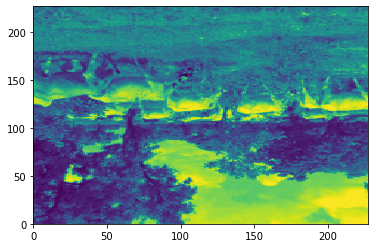

In [4]:
plt.figure();
plt.pcolormesh(nsd_im)

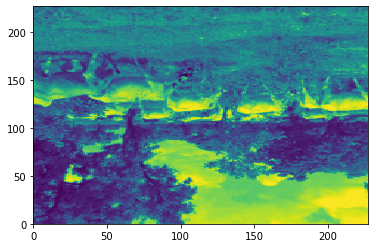

In [5]:
plt.figure();
plt.pcolormesh(images[0,0,:,:])

In [4]:
# n_ori = 36
# n_sf = 12

n_ori=8;
n_sf=3
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
# cyc_per_stim = logspace(n_sf)(3., 72.)
cyc_per_stim = logspace(n_sf)(20,72)

x,y,sigma = [0,0,0.05]

In [6]:
# This is the version of the filtering code that came from NSD OSF repository

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]


pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    

maps_gab = _fmaps_fn(_to_torch(images[0:2],device=device))
maps_gab = [maps_gab[sf].detach().cpu().numpy() for sf in range(len(maps_gab))]

/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [11]:
## This is older version of filtering code; not torch/runs on CPU. slow...

# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)

# all_feat = g.get_nsd_gabor_feat(nsd_inds[0:2], bank, use_freq=True)
all_feat = g.get_nsd_gabor_feat(nsd_inds[0:2], bank, use_freq=False)
 
maps_old = all_feat

  0%|          | 0/2 [00:00<?, ?it/s]

size of filter stack will be:
(635, 635, 24)


100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


In [12]:
# Parameters

freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [14]:
## Testing spatial version
gc.collect()
torch.cuda.empty_cache()

n_images= 10
sample_batch_size=1

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)


maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_spat))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

took 0.03 s to make filters
(10, 227, 227, 24)
total time is 0.32 s


In [15]:
## Testing frequency version

n_images= 10
sample_batch_size=2
filter_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_freq(bank, filter_batch_size, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_freq = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_freq))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

size of filter stack will be:
(635, 635, 24)
took 1.88 s to make filters
(10, 227, 227, 24)
total time is 2.24 s


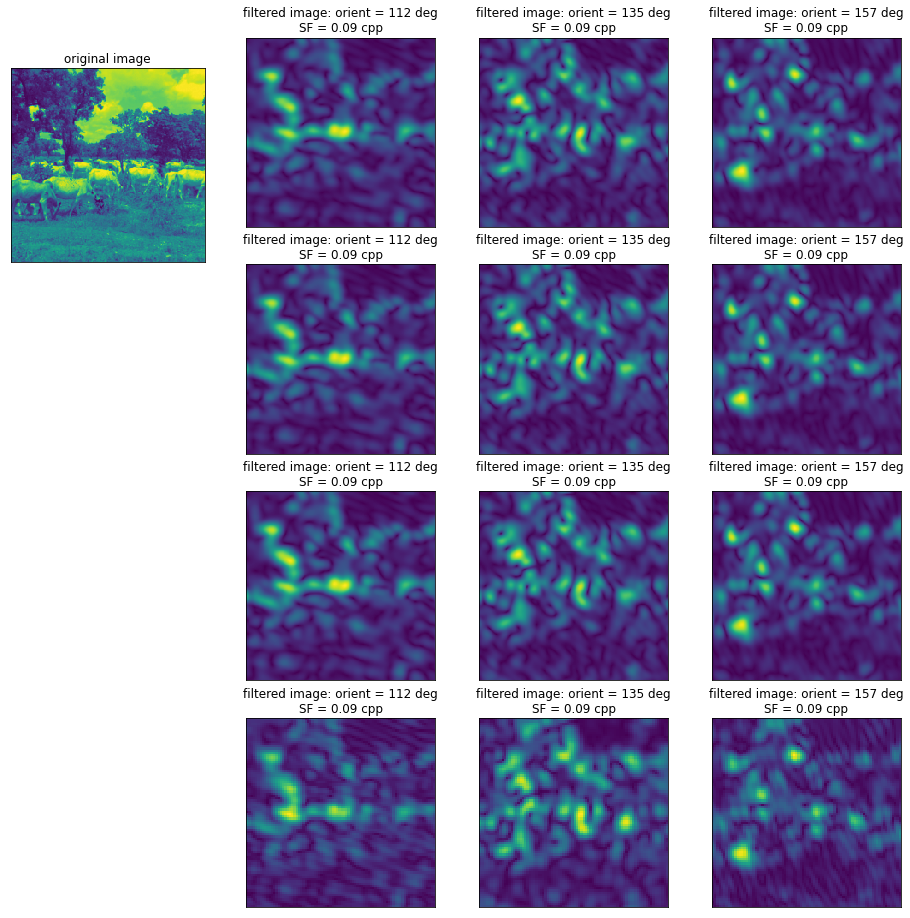

In [16]:
# Plotting all methods side by side

image_ind = 0

orient_labs = bank.orient_labs
a,orient_ind_list = np.unique(orient_labs,return_inverse=True)
freq_labs = bank.freq_labs
a,freq_ind_list = np.unique(freq_labs,return_inverse=True)

nFilts = len(orient_labs)

# ori2plot = (np.array([90,90,90])/5).astype('int')
# sf2plot = np.array([2,6,10]).astype('int')
ori2plot = (np.array([5,6,7])).astype('int')
sf2plot = np.array([0,0,0]).astype('int')


plt.figure(figsize=(16,16));

plt.subplot(3,4,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    ff = np.where(np.logical_and(orient_ind_list==ori2plot[ii], freq_ind_list==sf2plot[ii]))[0][0];
   
    plt.subplot(4,4,2+ii)
    plt.pcolormesh(maps_freq[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4,4,6+ii)
    plt.pcolormesh(maps_spat[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
   
    plt.subplot(4,4,10+ii)
    plt.pcolormesh(maps_old[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4,4,14+ii)
    plt.pcolormesh(maps_gab[sf2plot[ii]][image_ind,ori2plot[ii],:,:])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])

In [14]:
ori2plot

array([18, 18, 18])